##  Integrated Gradients Exercise

An exercise employing integrated gradients (IG) is performed.  IG is a methodology used to help understand and explain how some ML models arrive at their conclusions.  Discusssed and formally presented  [here](https://arxiv.org/abs/1703.01365) I consider the their use as a way to take the model and place it as the subject of scrutiny rather than data.  The model, presented various input data in a systematic fashion, itself becomes the target of a mini-investigation.

Using MNIST data, a 4 similar to a 9, IG are used to show what part of the image is most impactful in reclassifying the 4 as a 9.  [MNIST](http://yann.lecun.com/exdb/mnist/) is a popular dataset of images of numbers for their classification.  Different people and classifiers might confuse different numbers with eachother.  I think many would agree that pairs of numbers easily mistaken might be 1/7, 3/8, and 4/9.  1/7 for the small "tick" at the top ; 3/8 and 8 for the "loops" being partial or complete, and 4/9 for how curvy (or straight) or *connected* the top might be or how curvy or straight the bottom might be.  Some 4 have a "closed" polygon at the top while others have an open one.  4 and 9 are used in this exercise because the source of confusion might be most easily attributable to the top part depending on the curve or connection.  

A "confusion matrix" [here](https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html) shows an example of how some numbers are mis-classified

The model porition of this notebook is based on [this example](https://keras.io/examples/vision/mnist_convnet/).  

#### Load Modules

In [1]:
from tensorflow.python import pywrap_tensorflow as _pywrap_tensorflow
from tensorflow.python.eager import context
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import os
import json
from datetime import datetime


#### Load Data, Train a Model

In [2]:
#prep the data
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [3]:
#Based on the model here : https://keras.io/examples/vision/mnist_convnet/
model_save_file="MNIST_GD_model_file.h5"
loadedModelFromFile=False
def create_model_arch():
    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    return model
if(os.path.exists(model_save_file)):
    model=keras.models.load_model(model_save_file)
    loadedModelFromFile=True
    print(f"Loaded existing model from {model_save_file}")
else:
    model=create_model_arch()
    print(f"Did not find model file, so creating a model!")
model.summary()

Loaded existing model from MNIST_GD_model_file.h5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense 

In [4]:
if(not(loadedModelFromFile)):
    print(f"Since model not loaded from file, {model_save_file} , to begin training!")
    batch_size = 128
    epochs = 60
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1,verbose=False)
    model.save_weights(model_save_file)
    model.save(model_save_file)
    print(f"Model saved to file {model_save_file}")
else:
    print(f"Since model loaded from file, SKIPPING retraining!")

Since model loaded from file, SKIPPING retraining!


####  A Brief Report on the Model's Performance

In [5]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.026806853711605072
Test accuracy: 0.9932000041007996


### Chose a 4 and 9 to Compare and Analyze With

The training data are analyzed to find examples of 4s and examples of 9s.  Once those data are gathered (4s and 9s), each instance of 4 is compared with each instance of 9.  For each pair, a similarity score is computed as the sum of the absolute values of differences among the pixels.  There are 28x28=784 pixels so each similarity score requires at least that many computations.

After the comparisons are carried out the most similar 4 and similar 9 are found and they are the 4 and 9 that will be used for subsequent analysis with integrated gradients.  Because the similarity scores might take some time to compute the values I found (indexes 2662 and 5059 into the training data) are saved into the code below.  Small modification can be done by remove them as well as a "break" statement from the search loop ; that modification would trigger the FxN comparisons instead of using the "cached" index values (F=number of fours=5842; N=number of nines=5949)

In [6]:
four_indices=[i for i in range(len(y_train)) if tf.keras.backend.argmax(y_train[i])==4]
nine_indices=[i for i in range(len(y_train)) if tf.keras.backend.argmax(y_train[i])==9]
print(f"Num 4-indices is {len(four_indices)}")
print(f"Num 9-indices is {len(nine_indices)}")
pd_data_dict={'four_index':[],'nine_index':[],'abs_diff':[]}
import pandas as pd
for fii  in range(len(four_indices)):
    if(fii%250==0):
        print(f"On 4-index {fii} of {len(four_indices)}...")
    for nii in range(len(nine_indices)):
        fi=four_indices[fii]
        ni=nine_indices[nii]
        diff=x_train[fi]-x_train[ni]
        abs_diff=abs(diff)
        sum_abs_diff=sum(sum(abs_diff))
        pd_data_dict['four_index'].append(fii)
        pd_data_dict['nine_index'].append(nii)
        pd_data_dict['abs_diff'].append(float(sum_abs_diff))
    #this code is added so as to break out of the loop
    # indices were computed and are "cached" in some lines below and
    # are loaded there.  They can be recomputed by small modification
    # of eliminating this break check.
    if fii==0:
        break
#here, load the "cached" data
pd_data_dict={'four_index':[2662],'nine_index':[5059],'abs_diff':[21.780394]}
sim_data_df=pd.DataFrame.from_dict(pd_data_dict)
sim_data_df.sort_values('abs_diff',inplace=True, kind='quicksort')
print(sim_data_df.head())
four_index_to_use=sim_data_df['four_index'].tolist()[0]
print(f"4-index to use is {four_index_to_use}")
first_four_index=four_indices[four_index_to_use]
nine_index_to_use=sim_data_df['nine_index'].tolist()[0]                              
print(f"9-index to use is {nine_index_to_use}")                              
first_nine_index=nine_indices[nine_index_to_use]

Num 4-indices is 5842
Num 9-indices is 5949
On 4-index 0 of 5842...
   four_index  nine_index   abs_diff
0        2662        5059  21.780394
4-index to use is 2662
9-index to use is 5059


#### Data Verification and Inspection

With the data selected, verify that the 4 is classified as a four and that the 9 is classified as a 9.

Next each of the data are visualized.  By visual inspection their similarity can be further assessesed.  The difference between the 4 and the 9 is that the 4 is either 
*  being drawn as on an 8-segment display , but whose lines are a bit curved, or
*  as an ASCII 4 (here!) but whose triangle isn't quite closed at the top.

In either case the main difference between the 4 and the 9 is at the top where either the four has curves (first case) or its triangle doesn't quite close (second case above).


In [7]:
names=["four","nine"]
indices=[first_four_index,first_nine_index]
prediction_rec_dict=dict()
for ii in range(len(indices)):
    i=indices[ii]
    #print("i is "+str(i))
    a_data=x_train[i].reshape(1, 28, 28, 1)
    val=y_train[i]
    prediction=model.predict(a_data)[0]
    prediction_int=tf.keras.backend.argmax(prediction)
    real_answer=val
    real_answer_int=tf.keras.backend.argmax(real_answer)
    print(f"For the {names[ii]}, its prediction is pred={prediction}={prediction_int}\n  which is the same as {real_answer_int} from the training classification")
    prediction_rec_dict[names[ii]]=prediction.tolist()
    if(real_answer_int!=prediction_int):
        raise Exception("Discrepancy!")
print(json.dumps(prediction_rec_dict,indent=4))

For the four, its prediction is pred=[1.3490973e-15 1.3150611e-11 4.2186588e-11 2.1784472e-13 9.9852967e-01
 5.4825312e-13 5.5986379e-16 4.8584674e-09 3.3631868e-09 1.4702890e-03]=4
  which is the same as 4 from the training classification
For the nine, its prediction is pred=[1.39640285e-14 3.79004727e-12 2.75150236e-10 3.52829552e-08
 2.01680978e-05 1.21221375e-11 1.47250251e-15 5.70655800e-07
 5.47441778e-06 9.99973774e-01]=9
  which is the same as 9 from the training classification
{
    "four": [
        1.3490973271791835e-15,
        1.3150610808643215e-11,
        4.2186587556614086e-11,
        2.1784471741694705e-13,
        0.9985296726226807,
        5.482531204199781e-13,
        5.598637906631485e-16,
        4.858467406165801e-09,
        3.3631868401329257e-09,
        0.001470288960263133
    ],
    "nine": [
        1.3964028467339153e-14,
        3.790047269081054e-12,
        2.751502359288338e-10,
        3.528295522414737e-08,
        2.0168097762507387e-05,
     

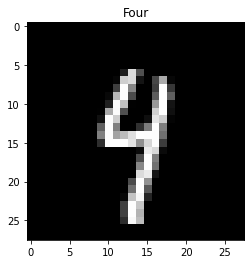

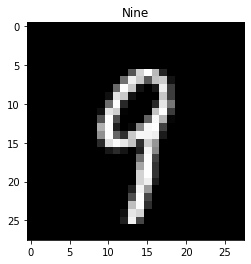

In [8]:
import matplotlib.pyplot as plt
def plotImg(img_data,cmap='gray',t=None):
    fig = plt.figure
    plt.imshow(img_data, cmap=cmap)
    if(t is not None):
        plt.title(t)
    plt.show()    
four_image = x_train[first_four_index]
plotImg(four_image,t="Four")
nine_image = x_train[first_nine_index]
plotImg(nine_image,t="Nine")


## Gradients

Applying equation 3 from the [paper](https://arxiv.org/abs/1703.01365) (see below), integrated gradients are computed
$
IG_{i} = (x_{i}-b_{i}) \cdot  \Sigma_{\alpha=0}^{\alpha=1} \frac{\partial F_{i}(b+\alpha (x-b))}{ \partial x_{i}}.
$
In this case, a "neutral" baseline is not used.  "Neutral" baseline could be an input that when fed to the model results in a uniform output classification where each number is declared equally likely $ P(X=0)=P(X=1)=...=P(X=9)=\frac{1}{10}$.  **In contrast the baseline used here is 4 and 9 as the primary data under consideration.  This way, IG might help reveal what about the 9-image makes it classified as a 9 and not a 4.**

Note that in the calculation, the derivative (gradient) is taken with respect to the 9th output as the Y variable because that is the target.

Furthermore, in the approximation here, the $\alpha$ variable transits from 0 to 1 with step 0.001 to help precision.

In [9]:
baseline=four_image
data_for_ig=nine_image
gradient_list=list()
for alpha in [float(alpha)*0.001 for alpha in range(1,1000,1)]:
    alpha_image=baseline+(data_for_ig-baseline)*alpha
    alpha_img_for_pred=tf.convert_to_tensor(alpha_image.reshape(1, 28, 28, 1))
    with tf.GradientTape() as g:
        g.watch(alpha_img_for_pred)
        alpha_prediction=model(alpha_img_for_pred)
        dpred_dimg_at_alpha=g.gradient(alpha_prediction[0][9],alpha_img_for_pred)
        #dimg_dpred_at_alpha_as_np=dimg_dpred_at_alpha.numpy()
        gradient_list.append(dpred_dimg_at_alpha*0.001*(data_for_ig-baseline))

### Check the Work
From the paper, "we recommend that developers check that the attributions approximately adds up to the difference beween the score at the input and that at the baseline, and if not increase the step-size m."

The change in probability is computed and it matches the IG sum !

In [10]:
prob_jump=prediction_rec_dict['nine'][9]-prediction_rec_dict['four'][9]
print("The change in probability is "+str(prob_jump))
attrib_sum=0
for g_i in range(len(gradient_list)):
    attrib_sum+=tf.math.reduce_sum(gradient_list[g_i])
attrib_sum=float(attrib_sum.numpy())
print("The attribution sum is "+str(attrib_sum))
attrib_sum_and_prob_jump_diff=abs(prob_jump-attrib_sum)
print("The difference is "+str(attrib_sum_and_prob_jump_diff))
if attrib_sum_and_prob_jump_diff<=0.01:
    print("The two values are quite close!")
else:
    print("The two values are not close, is better precision needed?  Are the IG correctly computed?")

The change in probability is 0.9985034849960357
The attribution sum is 0.9986327886581421
The difference is 0.00012930366210639477
The two values are quite close!


#### Gradient Post-Processing

So as to help reveal what *promotes* classification of the data to be a nine and ignore what *detracts* the data from being classified as a 9, the gradients are subjected to some post-processing.  Here the first post-processing of IG is that any negative values are capped at zero.  This helps to ignore "detractor" features.   Positive values are left unchanged.

In [11]:
#throw away negs
gradien_list_pos=[g for g in gradient_list]
for g_i in range(len(gradient_list)):
    ag=gradient_list[g_i].numpy().reshape(28*28)
    drop_neg=lambda x : 0 if x<=0 else x
    ag=[drop_neg(x) for x in ag]
    gradien_list_pos[g_i]=tf.convert_to_tensor(np.array(ag).reshape(1, 28, 28, 1))

### A Bit More Post-Processing and Integration Completion

With detractors discarded a next step is to turn the IG into something usable.  To do so, each of the gradients at each of the $\alpha$ values are summed; this summing completes the integral calculation.  Next, the value of each gradient is set to itself as a fraction of the maximal gradient.  This normalizes everything in the range from 0.0 to 1.0

In [12]:
gl_sum=gradien_list_pos[0]
for i in range(1,len(gradien_list_pos)):
    gl_sum=gl_sum+gradien_list_pos[i]
gl_sum=gl_sum.numpy().reshape(28,28,1)
gl_sum_copy=np.copy(gl_sum)
gl_sum_norm=np.copy(gl_sum)
gl_sum_copy=gl_sum_copy.reshape(28*28)
max_gl=max(gl_sum_copy)
sorted_gl_vals=sorted(gl_sum_copy.tolist())
def normTheSum(x):
    return float(x)/float(max_gl)
normTheSumVec=np.vectorize(normTheSum)
gl_sum_norm=normTheSumVec(gl_sum_norm)
gl_sum_norm_argmax=np.unravel_index(np.argmax(gl_sum_norm, axis=None), gl_sum_norm.shape)
print(f"Location of the highest post-processed IG is {gl_sum_norm_argmax}")

Location of the highest post-processed IG is (6, 15, 0)


## Application & Visualization!

The baseline image is visualized (for convenience).  Next, the post-processed gradients gradients are visualized.  
By visual inspection, the post-processed gradient sum has a peak/mode at around (6,15).  This location is exactly where the loop/triangle/polygon of the 4 is open/uncompleted.  This value is shown/computed in the previous cell as well.

Finally, the post-processed gradients are merged into the baseline value via addition.  As this is done, some minor image processis is carried out where pixel values are capped at 1.0 so that all pixel values are between 0 and 1.0

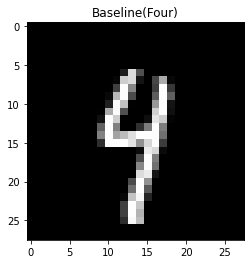

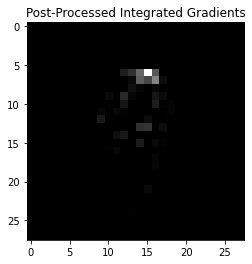

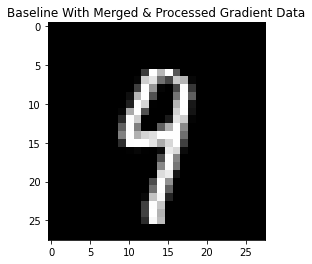

In [13]:
def capAt(x,cap=1):
    if(x>cap):
        return cap
    else:
        return x
vecCap=np.vectorize(capAt)
plotImg(baseline,t="Baseline(Four)")
plotImg(gl_sum_norm,t="Post-Processed Integrated Gradients")
gl_sum_wbl=vecCap(gl_sum_norm+baseline)
plotImg(gl_sum_wbl,t="Baseline With Merged & Processed Gradient Data")

### Taking the 4 merged with the IG-pixels the data is now classified as a 9

In [14]:
model.predict(gl_sum_wbl.reshape(1, 28, 28, 1))[0].tolist()

[4.535420636601027e-14,
 2.4610847214334708e-12,
 5.366002087114907e-10,
 2.1015009177283162e-10,
 0.006022866815328598,
 7.966237045020641e-12,
 1.0129502903580647e-15,
 8.528211310476763e-07,
 4.04130162223737e-07,
 0.9939759373664856]

According to the output from the classifier, the prediction for 9 is 99.39%.

## Brief Discussion

I consider it pleasing and intuitive that the processed gradients have a peak/mode at precisely the point where when merged into the baseline four allow it to be considered as a 9.  That point closes the top box (or triangle) of the four when then permits its classification as a 9.

This observation gives me some confidence that the model is working as expected and in an intuitive way.  Furthermore, it gives me some confidence that the IG methodology has been correctly implemented.